In [1]:
import numpy as np
import itertools
import random
from matplotlib import pyplot as plt
from multiprocessing import Pool
import multiprocessing
from collections import defaultdict
import os
import shutil

INITIAL_GENES = 20
INITIAL_NUMBER_OF_WEIGHTS = 1

print(multiprocessing.cpu_count())

!pip install python-resize-image

4


In [2]:
from resizeimage import resizeimage
import urllib.request
from PIL import Image, ImageDraw


def rgba_to_rgb(png):
    background = Image.new("RGB", png.size, (255, 255, 255))
    background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
    return background

# url1 = "https://ak7.picdn.net/shutterstock/videos/6520817/thumb/1.jpg"
# url1 = "https://www.it-times.de/resources/dam/asset/16321/social_networks.jpg"
# url1 = "https://pngicon.ru/file/uploads/google.png"
# url1 = "https://sun9-39.userapi.com/c831409/v831409508/174e7d/zduwueBls78.jpg"
# url1 = "https://www.theinvisibletourist.com/wp-content/uploads/2017/04/featured_85.jpg"
# url1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/%C3%81guila_calva.jpg/1200px-%C3%81guila_calva.jpg"


url1 = "https://media-cdn.tripadvisor.com/media/photo-s/13/36/6a/95/caption.jpg"
# url1 = "https://i.imgur.com/IqW6LtA.jpg"
# url1 = "https://i.imgur.com/GfHJFdg.jpg"
# url1 = "https://images.unsplash.com/photo-1440512230362-93f3eda28662?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=2100&q=80"
# url1 = "https://avatars.mds.yandex.net/get-pdb/909745/dbd65971-d215-4a5e-a2d5-f3ae141bb902/s1200"

image = Image.open(urllib.request.urlopen(url1))
cover = resizeimage.resize_cover(image, [512, 512])
# cover = resizeimage.resize_thumbnail(image, [512, 512])
try:
    rgba_to_rgb(cover).save('test.png')
except:
    cover.save('test.png')

In [3]:
class Gene:
    def __init__(self, img, target, fitness_value):
        self.img = img.copy()
        self.target = target
        self.fitness_value = fitness_value


    def put_figure(self, figure):
        canvas = ImageDraw.Draw(self.img, "RGB")
        if figure == 1:
            place = get_random_item(2)
            min_i, min_j = place[0]
            max_i, max_j = place[1]
            y, x, r = min_j, min_i, max([max_j - min_j, max_i - min_i])
            previous_score = self.get_diff_at_rectangle(y, x, r)
            i, j = get_pixel_coord_from_center(place)
            color = tuple(self.target[j, i])
            canvas.ellipse(place, fill=color)
            self.last_circle = place
            new_score = self.get_diff_at_rectangle(y, x, r)
            self.fitness_value -= previous_score - new_score
        else:
            place = get_random_item(3)
            self.put_triangle(place)
        return self


    def put_triangle(self, place):
        canvas = ImageDraw.Draw(self.img, "RGB")
        place = get_random_item(3)
        min_i, min_j = min([xy[0] for xy in place]), min([xy[1] for xy in place])
        max_i, max_j = max([xy[0] for xy in place]), max([xy[1] for xy in place])
        y, x, r = min_j, min_i, max([max_j - min_j, max_i - min_i])
        previous_score = self.get_diff_at_rectangle(y, x, r)
        i, j = get_pixel_coord_from_center(place)
        color = tuple(self.target[j, i])
        canvas.polygon(place, fill=color)
        new_score = self.get_diff_at_rectangle(y, x, r)
        self.fitness_value -= previous_score - new_score
        self.last_triangle = place


    def get_diff_at_rectangle(self, x, y, r):
        return np.sum(np.abs(self.target[x:x+r+1, y:y+r+1] -
                                       np.array(self.img, np.int16)[x:x+r+1, y:y+r+1]))


    def get_image(self):
        return self.img

    
    def get_fitness_value(self):
        return self.fitness_value


    def copy(self):
        return Gene(self.img, self.target, self.fitness_value)

    def save(self, name):
        if not os.path.exists('saves'):
            os.mkdir('saves')

        self.get_image().save(f'saves/{name}.jpg')


def merge(g1, g2):
    back = g1.get_image().copy()
    im = g2.get_image().crop((256, 0, 512, 512))
    back.paste(im, (256, 0))
    return Gene(back, g1.target, fitness_function(g1.target, back))


def get_pixel_coord_from_center(points):
    x = sum([xy[0] for xy in points]) // len(points)
    y = sum([xy[1] for xy in points]) // len(points)
    return x, y



def diff_2_images(target, generated):
    target_pixels = target
    generated_pixels = np.array(generated, np.int16)
    return np.sum(np.abs(generated_pixels - target_pixels))
    # return np.sum((np.abs(target_pixels[:, :, :-1] - generated_pixels[:, :, :])))


def fitness_function(target, generated_pixels):
    return diff_2_images(target, generated_pixels)


def get_random_item(points=2):
    

    if points == 2:
        r_min, r_max = 20, 50

        x1 = np.random.randint(0, 512)
        y1 = np.random.randint(0, 512)
        r = np.random.randint(r_min, r_max)
        x2 = np.random.randint(x1, min(512, x1 + r))
        r = np.random.randint(r_min, r_max)
        y2 = np.random.randint(y1, min(512, y1 + r))
        return [(x1, y1), (x2, y2)]
    else:
        r_min, r_max = 10, 40

        x1 = np.random.randint(0, 512)
        y1 = np.random.randint(0, 512)
        r = np.random.randint(r_min, r_max)
        x2 = np.random.randint(max(0, x1 - r), min(512, x1 + r))
        r = np.random.randint(r_min, r_max)
        y2 = np.random.randint(max(0, y1 - r), min(512, y1 + r))
        r = np.random.randint(r_min, r_max)
        x3 = np.random.randint(max(0, x2 - r), min(512, x2 + r))
        r = np.random.randint(r_min, r_max)
        y3 = np.random.randint(max(0, y2 - r), min(512, y2 + r))
        return [(x1, y1), (x2, y2), (x3, y3)]


def initial_population(target, fitness, num):
    return [Gene(Image.new("RGB",(512,512), (255,255,255)), target, fitness) for i in range(num)]


def crossover(new_circles, new_triangles):
    new = []
    best_triangle = get_the_best(new_triangles)
    best_circle = get_the_best(new_circles)
    best_circle.put_triangle(best_triangle.last_triangle)
    return best_circle


def get_the_best(population):
    # parents = sorted(population, key=lambda x: fitness_function(target, x))[:num_parents]
    parent = min(population, key=lambda x: x.get_fitness_value())
    return parent

def group_mutation(best_gene, num):
    new_circles = [best_gene.copy().put_figure(1) for i in range(num // 2)]
    new_triangles = [best_gene.copy().put_figure(2) for i in range(num // 2)]
    return new_circles, new_triangles

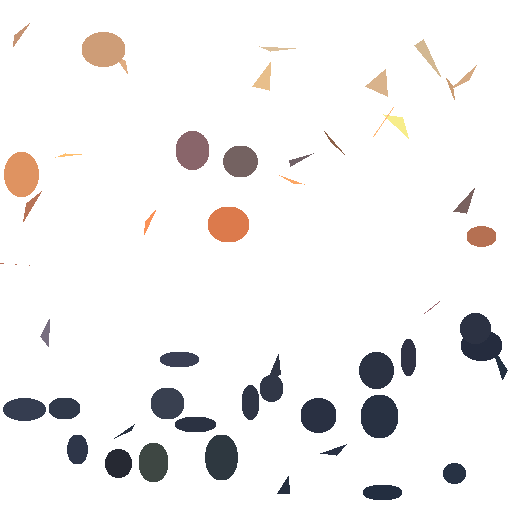

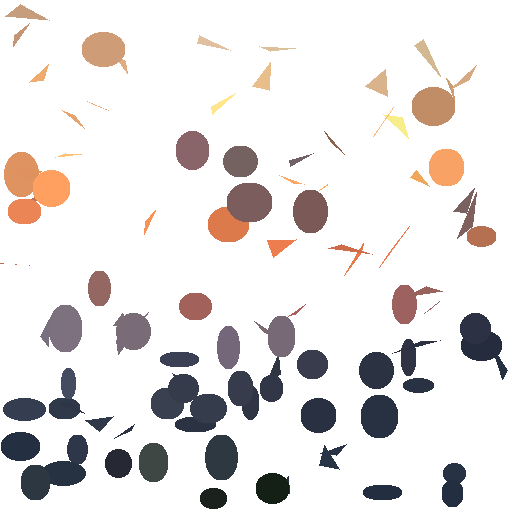

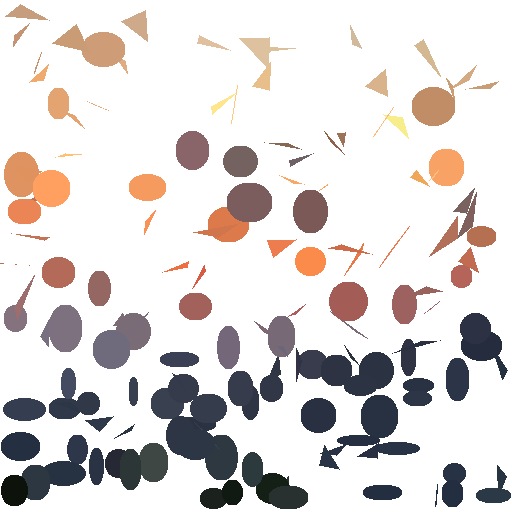

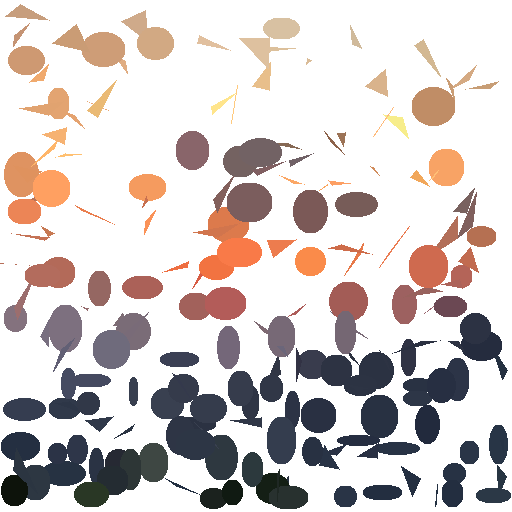

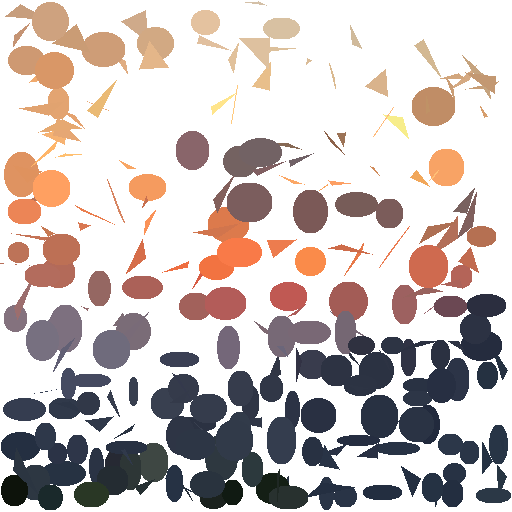

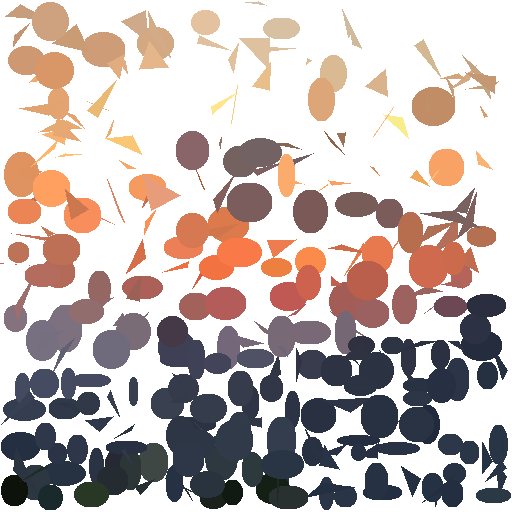

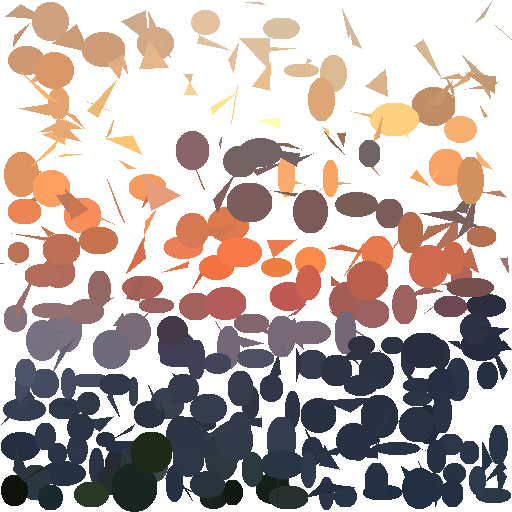

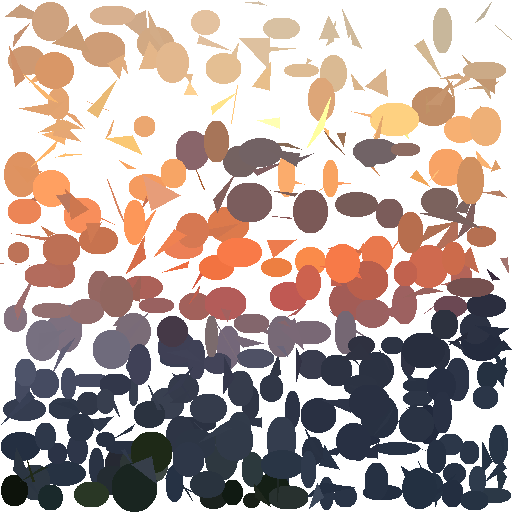

In [4]:
save = True

num = 55

# iterations = 3_000
iterations = 200

target = Image.open('test.png')

# new_population = [parent]
target_image = np.array(target, np.int16)

empty_image = Image.new("RGB",(512,512), (255,255,255))
fit = fitness_function(target_image, empty_image)
parent = Gene(empty_image, target_image, fit)

if save and os.path.exists('saves'):
    shutil.rmtree('saves')


for iteration in range(iterations + 1):
    # parent = get_the_best(new_population)
    if iteration and iteration % 25 == 0:
        display(parent.get_image())
        if save and iteration % 50 == 0:
            parent.save(f'image{iteration}')
    new_circles, new_triangles = group_mutation(parent, num)
    parent = crossover(new_circles, new_triangles)